In [1]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np

In [3]:
np.__version__

'1.26.2'

In [4]:
import cv2
from glob import glob

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Activation, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger,  ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [102]:
from sklearn.metrics import f1_score

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
H = 128
W = 128
batch_size = 8
epochs = 100
lr = 1e-4
num_classes = 11

In [8]:
main_path = "/kaggle/input/human-face-segmentation/LaPa"

In [9]:
os.path.join(main_path, 'train', 'labels', '10001436895_0.png')

'/kaggle/input/human-face-segmentation/LaPa/train/labels/10001436895_0.png'

In [10]:
def load_images(path):
    train_x = sorted(glob(os.path.join(path, 'train', 'images', '*.jpg')))
    train_y = sorted(glob(os.path.join(path, 'train', 'labels', '*.png')))
    
    test_x = sorted(glob(os.path.join(path, 'test', 'images', '*.jpg')))
    test_y = sorted(glob(os.path.join(path, 'test', 'labels', '*.png')))
    
    val_x = sorted(glob(os.path.join(path, 'val', 'images', '*.jpg')))
    val_y = sorted(glob(os.path.join(path, 'val', 'labels', '*.png')))
    
    return (train_x, train_y), (test_x, test_y), (val_x, val_y)

In [11]:
(train_x, train_y), (test_x, test_y), (val_x, val_y) = load_images(main_path)

In [12]:
print("train_x shape : ", len(train_x))
print("train_y shape : ", len(train_y))
print("test_x shape : ", len(test_x))
print("test_y shape : ", len(test_y))
print("val_x shape : ", len(val_x))
print("val_y shape : ", len(val_y))

train_x shape :  18168
train_y shape :  18168
test_x shape :  2000
test_y shape :  2000
val_x shape :  2000
val_y shape :  2000


In [13]:
train_x[0]

'/kaggle/input/human-face-segmentation/LaPa/train/images/10001436895_0.jpg'

In [14]:
train_y[0]

'/kaggle/input/human-face-segmentation/LaPa/train/labels/10001436895_0.png'

In [15]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    y = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H))
    y = y.astype(np.int32)
    return y

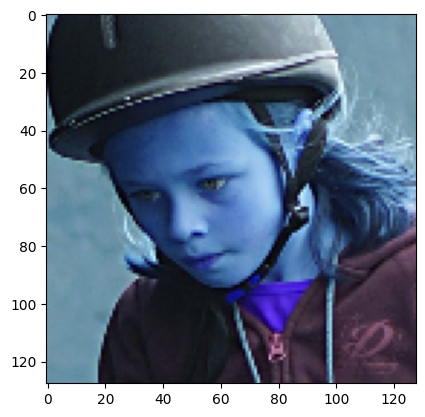

In [16]:
plt.imshow(read_image(train_x[0]))

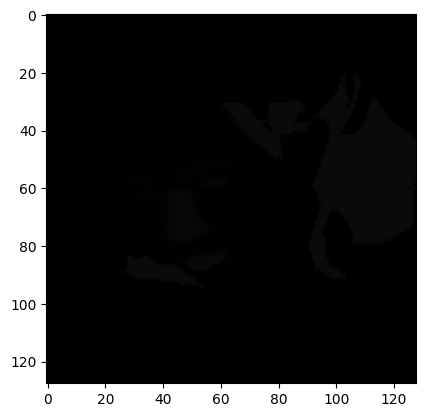

In [17]:
plt.imshow(read_image(train_y[0]))

In [18]:
trainX = [read_image(x) for x in train_x]
trainY = [read_mask(x) for x in train_y]

testX = [read_image(x) for x in test_x]
testY = [read_mask(x) for x in test_y]

valX = [read_image(x) for x in val_x]
valY = [read_mask(x) for x in val_y]

In [19]:
len(trainX)

18168

In [20]:
trainX[0]

array([[[0.41960785, 0.57254905, 0.64705884],
        [0.43529412, 0.5803922 , 0.64705884],
        [0.41568628, 0.58431375, 0.6509804 ],
        ...,
        [0.46666667, 0.62352943, 0.67058825],
        [0.4627451 , 0.61960787, 0.6901961 ],
        [0.46666667, 0.627451  , 0.7019608 ]],

       [[0.4117647 , 0.5764706 , 0.63529414],
        [0.43137255, 0.6       , 0.68235296],
        [0.42745098, 0.6117647 , 0.6862745 ],
        ...,
        [0.45490196, 0.60784316, 0.6627451 ],
        [0.46666667, 0.62352943, 0.68235296],
        [0.47058824, 0.62352943, 0.69803923]],

       [[0.44313726, 0.5921569 , 0.6509804 ],
        [0.44313726, 0.60784316, 0.69411767],
        [0.5019608 , 0.67058825, 0.7607843 ],
        ...,
        [0.4627451 , 0.60784316, 0.6627451 ],
        [0.4745098 , 0.6156863 , 0.6784314 ],
        [0.4745098 , 0.61960787, 0.69803923]],

       ...,

       [[0.4117647 , 0.5803922 , 0.6627451 ],
        [0.40392157, 0.57254905, 0.64705884],
        [0.40392157, 0

In [21]:
tr_x = trainX[:10000]
tr_y = trainY[:10000]

te_x = testX[:1000]
te_y = testY[:1000]

v_x = valX[:1000]
v_y = valY[:1000]

In [22]:
len(tr_x)

10000

In [26]:
tr_Y = tf.one_hot(tr_y, num_classes)

In [30]:
te_Y = tf.one_hot(te_y, num_classes)

In [31]:
v_Y = tf.one_hot(v_y, num_classes)

In [ ]:
def preprocess(x, y):
    def f(x, y):
        x = read_image(x)
        y = read_mask(y)      
        return x, y

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes)

    image.set_shape([H, W, 3])
    mask.set_shape([H, W, num_classes])

    return image, mask

In [32]:
def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.batch(batch).prefetch(2)
    return dataset

In [33]:
train_ds = tf_dataset(tr_x, tr_Y, batch=batch_size)

In [36]:
val_ds = tf_dataset(v_x, v_Y, batch=batch_size)

In [37]:
test_ds = tf_dataset(te_x, te_Y, batch=batch_size)

In [34]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 11), dtype=tf.float32, name=None))>

In [38]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding = 'same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [39]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2,2))(x)

    return x, p

In [40]:
def attention_block(s, g, num_filters):
    ws = Conv2D(num_filters, 1, padding = 'same')(s)
    ws = BatchNormalization()(ws)

    wg = Conv2D(num_filters, 1, padding = 'same')(g)
    wg = BatchNormalization()(wg)

    res = Activation('relu')(ws + wg)
    res = Conv2D(num_filters, 1, padding = 'same')(res)
    res = Activation('sigmoid')(res)

    return res * s

In [41]:
def decoder_block(inputs, skip_feat, num_filters):
    x = Conv2DTranspose(num_filters, 3, 2, padding = 'same')(inputs)
    s = attention_block(x, skip_feat, num_filters)
    s = Concatenate()([x,s])
    s = conv_block(s, num_filters)

    return s

In [42]:
def unet_model(input_shape):
    
    inputs = Input(input_shape)

    #Encoder Block
    skip1, res1 = encoder_block(inputs, 64)
    skip2, res2 = encoder_block(res1, 128)
    skip3, res3 = encoder_block(res2, 256)

    b1 = conv_block(res3, 512)
    
    #Decoder Block
    out1 = decoder_block(b1, skip3, 256)
    out2 = decoder_block(out1, skip2, 128)
    out3 = decoder_block(out2, skip1, 64)

    #Output
    final = Conv2D(num_classes, 1 , padding = 'same', activation = 'softmax')(out3)
    
    model = Model(inputs, final, name="UNET_Model")

    return model

In [43]:
model = unet_model((128,128,3))

In [44]:
model.summary()

Model: "UNET_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalization

In [45]:
model_path = "/kaggle/working/model.h5"
log_path = "/kaggle/working/log.csv"

In [46]:
callbacks = [ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(log_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)]

In [47]:
opt = keras.optimizers.Adam(learning_rate=0.01)

In [48]:
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [49]:
model.fit(train_ds, validation_data = val_ds, epochs = epochs, verbose = True, callbacks = callbacks)

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 0.5359
Epoch 1: val_loss improved from inf to 0.94069, saving model to /kaggle/working/model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - 120s 77ms/step - loss: 0.5359 - val_loss: 0.9407 - lr: 0.0100
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 0.3340
Epoch 2: val_loss improved from 0.94069 to 0.53888, saving model to /kaggle/working/model.h5
1250/1250 [==============================] - 95s 76ms/step - loss: 0.3340 - val_loss: 0.5389 - lr: 0.0100
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 0.2408
Epoch 3: val_loss improved from 0.53888 to 0.33810, saving model to /kaggle/working/model.h5
1250/1250 [==============================] - 95s 76ms/step - loss: 0.2408 - val_loss: 0.3381 - lr: 0.0100
Epoch 4/100
1250/1250 [==============================] - ETA: 0s - loss: 0.1967
Epoch 4: val_loss improved from 0.33810 to 0.32380, saving model to /kaggle/working/model.h5
1250/1250 [==============================] - 96s 77ms/step - loss: 0.1967 - val_loss: 0.3238 - lr: 0.0100
Epoch 5/100
1250/1250 [==============================] -

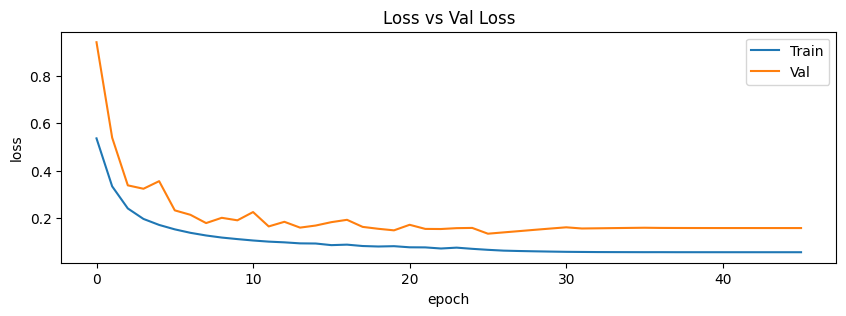

In [56]:
plt.figure(figsize=(10,3))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss vs Val Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [57]:
myModel = tf.keras.models.load_model("/kaggle/working/model.h5")

In [58]:
myModel.summary()

Model: "UNET_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalization

In [59]:
te_x[0]

array([[[0.40392157, 0.22745098, 0.21568628],
        [0.44313726, 0.25882354, 0.24313726],
        [0.43137255, 0.26666668, 0.24705882],
        ...,
        [0.53333336, 0.56078434, 0.54509807],
        [0.53333336, 0.5568628 , 0.5529412 ],
        [0.53333336, 0.54901963, 0.54509807]],

       [[0.44313726, 0.27450982, 0.2627451 ],
        [0.43137255, 0.2627451 , 0.25490198],
        [0.43529412, 0.25882354, 0.24313726],
        ...,
        [0.53333336, 0.5764706 , 0.5647059 ],
        [0.53333336, 0.5764706 , 0.5686275 ],
        [0.53333336, 0.5647059 , 0.56078434]],

       [[0.45882353, 0.2901961 , 0.2784314 ],
        [0.43529412, 0.27058825, 0.25882354],
        [0.45490196, 0.30588236, 0.28627452],
        ...,
        [0.5294118 , 0.5764706 , 0.5764706 ],
        [0.5529412 , 0.6       , 0.6       ],
        [0.5411765 , 0.59607846, 0.5882353 ]],

       ...,

       [[0.69411767, 0.75686276, 0.78431374],
        [0.6666667 , 0.73333335, 0.7607843 ],
        [0.627451  , 0

In [77]:
check = te_x[5]

In [78]:
check = check.reshape((1, 128,128,3))

In [79]:
pred = model.predict(check)[0]

1/1 [==============================] - 0s 21ms/step


In [80]:
pred = np.argmax(pred, axis = -1)

In [81]:
pred.shape

(128, 128)

In [82]:
pred = pred * (255/11)

In [83]:
pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

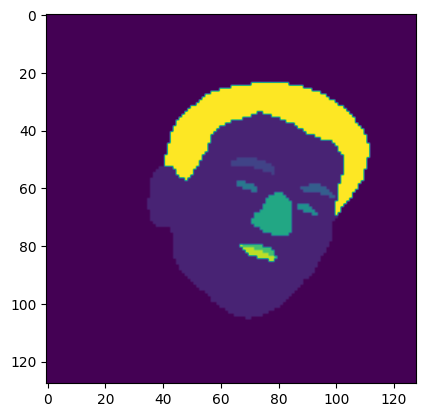

In [84]:
plt.imshow(pred)

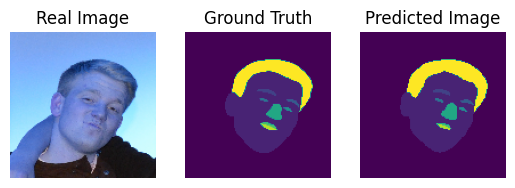

In [101]:

plt.subplot(1,3,1)
plt.imshow(te_x[5])
plt.title('Real Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(te_y[5])
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(pred)
plt.title('Predicted Image')

plt.axis('off')
plt.show()

# Thanks